In [1]:
%reload_ext autoreload
%autoreload 2

# Week 5: Systematically Improving Your RAG Application

## Why Use Language Models for Metadata Generation?

We need to return results that are both relevant and accurate based on the user's query. This requires us to use effective filtering mechanisms. We want to use language models to generate these metadata fields because they are fast and cheap. Using structured extraction, we can generate metadata fields that are more accurate and consistent than human annotators.

Why does this matter? Imagine a query from a user - "I'm looking for a black t-shirt under $50 made of cotton.

This seemingly simple request contains multiple filtering criteria:
- Color (black)
- Price range (under $50)
- Material preference (cotton)

Additionally, the system might have user-specific metadata like:
- Typical size preferences (S/M)
- Preferred brands (e.g., Zara)
- Shopping history

In this , we'll walk through two main steps:

1. **Database Creation**: We'll first use the `irow/ClothingControlV2` dataset to create a list of items that we can use to simulate a e-commerce company's SKU (Stock Keeping Unit) database that contains item titles, descriptions, product images, categories, and subcategories based off a taxonomy that we'll define

2. **SKU Data Simulation**: We'll then enrich this data with realistic product data including size distribution, stock quantity, product characteristics

3. **Limitations Of Embedding search**: We'll then briefly walk through where embedding search falls short and how we can leverage our LLM generated metadata to improve the retrieval ( including our SKU data simulations )

Once we've generated our dataset, we'll then upload it to hugging face for us to use in the next notebook, where we'll see how to benchmark the metadata fields using simple retrieval evals. 


## Loading in our Taxonomy

E-Commerce companies use what's called a taxonomy to classify their products. In our case, we've chosen the following fields

- `category` : This is a high level category such as Men's, Women's, Unisex, etc.
- `subcategory` : This is a more specific category such as T-Shirts, Blouses that are under a specific category
- `types` : These are more specific product types such as Crew Neck T-Shirt, V-Neck T-Shirt, etc.
- `attributes` These are attributes that are specific to the items that have that specific category, subcategory and type combination.
- `common_attributes` These are attributes that are common to all items in our database such as sizes and colors in stock

We want to define a taxonomy ahead of time for three main reasons

1. **Consistency** : By having a consistent taxonomy, we can ensure that we only generate data on items that fall within our taxonomy. 
2. **Filtering** : It makes it easy for us to map user queries to a set of known metadata fields which we can use to filter our retrieved items down the line.
3. **Non-Technical Help**: By using a human-readable format like yaml, we can ask members of our team that aren't technical to help define the proper taxonomy. You can implement this too using a no-sql database to store raw taxonomies or configs but we've chosen to keep it simply for now.

Let's now read in our taxonomy and see how we can enforce these fields. We'll define some simple Pydantic models to make it easy for us to work with the yaml data



In [3]:
from helpers import process_taxonomy_file

taxonomy_data = process_taxonomy_file("taxonomy.yml")

taxonomy_data.keys()

dict_keys(['taxonomy_map', 'occasions', 'materials', 'common_attributes', 'taxonomy'])

In [5]:
taxonomy_data["common_attributes"].keys()

dict_keys(['Size', 'Color', 'Material', 'Pattern', 'Occasion'])

With the exception of sizing, we can see that most of the common attributes can be extracted out of our taxonomy.

With that in mind, we want to define a pydantic model so that we can enforce these taxonomy fields. We want to do so because it allows us to then use `instructor` to extract out these fields from the images that are in the `irow/ClothingControlV2` dataset.

We can use a `model_validator` here to enforce that the given attributes are valid for the subcategory, category and type

In [17]:
from pydantic import model_validator, ValidationInfo, BaseModel


class ItemAttribute(BaseModel):
    name: str
    value: str


class ItemMetadata(BaseModel):
    title: str
    brand: str
    description:str
    category: str
    subcategory: str
    product_type: str
    attributes: list[ItemAttribute]
    material: str
    pattern: str

    @model_validator(mode="after")
    def validate_material_and_pattern(self, info: ValidationInfo):
        context = info.context
        if not context or not context["taxonomy_data"]:
            raise ValueError("Taxonomy data is required for validation")

        if self.pattern not in context["taxonomy_data"]["common_attributes"]["Pattern"]:
            raise ValueError(
                f"Pattern {self.pattern} is not a valid pattern. Valid patterns are {context['taxonomy_data']['common_attributes']['Pattern']}"
            )

        if self.material not in context["taxonomy_data"]["common_attributes"]["Material"]:
            raise ValueError(
                f"Material {self.material} is not a valid material. Valid materials are {context['taxonomy_data']['common_attributes']['Material']}"
            )

        return self

    @model_validator(mode="after")
    def validate_category_and_attributes(self, info: ValidationInfo):
        context = info.context
        if not context or not context["taxonomy_data"]:
            raise ValueError("Taxonomy data is required for validation")

        taxonomy_map = context["taxonomy_data"]["taxonomy_map"]

        # 1. Validate category
        if self.category not in taxonomy_map:
            raise ValueError(
                f"Category {self.category} is not valid. Valid categories are {list(taxonomy_map.keys())}"
            )

        # 2. Validate subcategory
        if self.subcategory not in taxonomy_map[self.category]:
            raise ValueError(
                f"Subcategory {self.subcategory} does not exist under category {self.category}"
            )

        subcategory_data = taxonomy_map[self.category][self.subcategory]

        # 3. Validate product type
        if self.product_type not in subcategory_data["product_type"]:
            raise ValueError(
                f"Product type {self.product_type} is not valid for subcategory {self.subcategory}. Valid types are {subcategory_data['product_type']}"
            )

        # 4. Validate attributes
        for attr in self.attributes:
            if attr.name not in subcategory_data["attributes"]:
                raise ValueError(
                    f"Attribute {attr.name} is not valid for subcategory {self.subcategory}. Valid attributes are {list(subcategory_data['attributes'].keys())}"
                )

            if attr.value not in subcategory_data["attributes"][attr.name]:
                raise ValueError(
                    f"Value {attr.value} is not valid for attribute {attr.name}. Valid values are {subcategory_data['attributes'][attr.name]}"
                )

        return self

## Extracting Item Data from Images

The `irow/ClothingControlV2` dataset contains images of clothing items that are generated using a control net. It doesn't have any product data and so we'll extract out the item data from the images. 

We use `instructor` here to help us extract the item data from the images. Note here that we're rendering the entire yml file as context. We want to do so for two reasons

1. Firstly, providing all of the possible choices allows the model more flexibility in deciding what the right metadata fields are
2. Secondly, if we have a large taxonomy, we can leverage techniques like prompt caching to save on costs. By ensuring that the initial portion of the prompt is the same, we can leverage caching to speed up the extraction process.

We'll be using `gpt-4o` here for the extraction since it supports multimodal inputs ( in this case images ) and has a relatively large context window.

In [9]:
from datasets import load_dataset

ds = [item for item in load_dataset("irow/ClothingControlV2",streaming=True)["train"].take(2)]


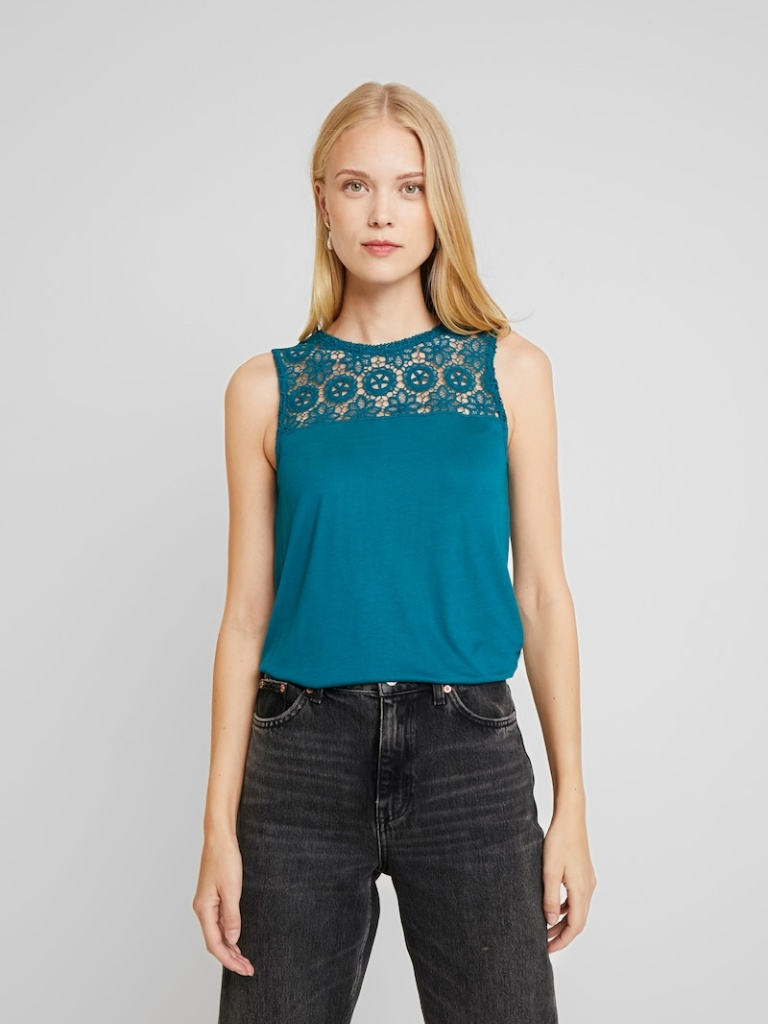

In [10]:
ds[0]["image"]

In [19]:
from openai import AsyncOpenAI
import instructor
import tempfile

client = instructor.from_openai(AsyncOpenAI())

with open("taxonomy.yml", "r") as f:
    taxonomy = f.read()

with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as f:
    ds[0]["image"].save(f.name)
    items = await client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "system",
                "content": "You are an expert at extracting item data from images. Extract 1-2 items seen in the images based on the taxonomy provided. Here are the categories, subcategories, types and attributes that you can choose from: {{ taxonomy_data['taxonomy_map'] }}",
            },
            {
                "role": "user",
                "content": [
                    "Here is the image, choose a brand that likely sells these items - choose a real brand that exists in real life and make up a name if that's not possible. Also generate a short description of 1-2 sentences of the item that would be suitable for an e-commerce website",
                    instructor.Image.from_path(f.name),
                ],
            },
        ],
        response_model=list[ItemMetadata],
        context={
            "taxonomy_data": taxonomy_data
        },
        
    )

    print(items)

[ItemMetadata(title='Lace Detail Sleeveless Top', brand='H&M', description='Elevate your wardrobe with this elegant sleeveless top featuring intricate lace detailing at the neckline. Perfect for a chic daytime look or a night out, this versatile piece combines comfort and style effortlessly.', category='Women', subcategory='Tops', product_type='Tank Tops', attributes=[ItemAttribute(name='Sleeve Length', value='Sleeveless'), ItemAttribute(name='Neckline', value='Crew Neck'), ItemAttribute(name='Fit', value='Regular')], material='Cotton', pattern='Solid')]


Now let's label a subset of the dataset with our taxonomy. We'll then upload it to huggingface for us to use in the next notebook

In [20]:
from openai import AsyncOpenAI
import instructor
import tempfile
from asyncio import Semaphore, timeout
from tenacity import retry, stop_after_attempt, wait_fixed
from tqdm.asyncio import tqdm_asyncio as asyncio


@retry(stop=stop_after_attempt(3), wait=wait_fixed(1))
async def generate_dataset_label(
    dataset_item: dict, client: instructor.AsyncInstructor, sem: Semaphore, taxonomy_data: dict
):
    async with sem, timeout(30):
        with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as f:
            dataset_item["image"].save(f.name)
            items = await client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {
                        "role": "system",
                        "content": "You are an expert at extracting item data from images. Extract 1-2 items seen in the images based on the taxonomy provided. Here are the categories, subcategories, types and attributes that you can choose from: {{ taxonomy_data['taxonomy_map'] }}",
                    },
                    {
                        "role": "user",
                        "content": [
                            "Here is the image, choose a brand that likely sells these items - choose a real brand that exists in real life and make up a name if that's not possible. Also generate a short description of 1-2 sentences of the item that would be suitable for an e-commerce website",
                            instructor.Image.from_path(f.name),
                        ],
                    },
                ],
                response_model=list[ItemMetadata],
                context={
                    "taxonomy_data": taxonomy_data
                },
                
            )

            return [
                {"image": dataset_item["image"], "metadata": item} for item in items
            ]


In [30]:
from itertools import islice
import instructor

client = instructor.from_openai(AsyncOpenAI())
sem = Semaphore(15)
n_rows = 150

ds = [item for item in load_dataset("irow/ClothingControlV2",streaming=True)["train"].take(n_rows)]
results = await asyncio.gather(
    *[generate_dataset_label(ds_row, client, sem, taxonomy_data) for ds_row in ds]
)

100%|██████████| 150/150 [02:19<00:00,  1.08it/s]


Before we can create a dataset, we need to flatten the list of items we've extracted from the images. We'll also flatten the metadata fields so that we can create a dataset with the correct schema.

Note that for convinience here we'll just convert attributes into a json string.

In [31]:
# Flatten results list of lists into a single list
flattened_results = [item for sublist in results for item in sublist]
flattened_results[0]["metadata"].model_dump()

{'title': 'Lace Detail Sleeveless Top',
 'brand': 'H&M',
 'description': "Elevate your casual wardrobe with this elegant sleeveless top featuring intricate lace detailing at the neckline. Perfect for both day and night, it's crafted from a soft, breathable fabric for all-day comfort.",
 'category': 'Women',
 'subcategory': 'Tops',
 'product_type': 'Tank Tops',
 'attributes': [{'name': 'Sleeve Length', 'value': 'Sleeveless'},
  {'name': 'Neckline', 'value': 'Crew Neck'}],
 'material': 'Cotton',
 'pattern': 'Solid'}

In [32]:
import json
import random

def flatten_item(item: dict, id: int):
    flattened_item = {"image": item["image"], **item["metadata"].model_dump()}

    return {
        **flattened_item,
        "id": id,
        "price": round(random.uniform(10.0, 400.0),2),

        "attributes": json.dumps(flattened_item["attributes"]),
    }


hf_dataset_items = [flatten_item(item, id+1) for id, item in enumerate(flattened_results)]
hf_dataset_items[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x1024>,
 'title': 'Lace Detail Sleeveless Top',
 'brand': 'H&M',
 'description': "Elevate your casual wardrobe with this elegant sleeveless top featuring intricate lace detailing at the neckline. Perfect for both day and night, it's crafted from a soft, breathable fabric for all-day comfort.",
 'category': 'Women',
 'subcategory': 'Tops',
 'product_type': 'Tank Tops',
 'attributes': '[{"name": "Sleeve Length", "value": "Sleeveless"}, {"name": "Neckline", "value": "Crew Neck"}]',
 'material': 'Cotton',
 'pattern': 'Solid',
 'id': 1,
 'price': 181.04}

In [33]:
# Now let's create a new HF dataset with the labelled data so that we have it stored
# Convert to HuggingFace Dataset format
from datasets import Dataset

# Create HF dataset
dataset = Dataset.from_list(hf_dataset_items)
dataset.push_to_hub("ivanleomk/ecommerce-taxonomy")


Uploading the dataset shards: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/ivanleomk/ecommerce-taxonomy/commit/f404c96bf9e1ec0d3de7026312f5bcd36f18ceef', commit_message='Upload dataset', commit_description='', oid='f404c96bf9e1ec0d3de7026312f5bcd36f18ceef', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/ivanleomk/ecommerce-taxonomy', endpoint='https://huggingface.co', repo_type='dataset', repo_id='ivanleomk/ecommerce-taxonomy'), pr_revision=None, pr_num=None)

In this simple notebook, we've seen the value of using LLMs to generate metadata for a RAG application. From a simple image, we were able to bootstrap a dataset with item metadata that allows us to return queries that are not only relevant but also accurate. 

In the next notebook, we'll generate some synthetic questions that require the use of complex metadata filtering to answer. We'll then see how we can use our LLM-generated metadata to improve the retrieval of these questions.